In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/housing.csv')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
df=df[(df['ocean_proximity']=='INLAND') |(df['ocean_proximity'] =='<1H OCEAN')]
df = df.fillna(0)
df.median_house_value=np.log1p(df.median_house_value)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['median_house_value']), df.median_house_value, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)



features = df.columns.drop('median_house_value')
train_dicts = X_train[features].to_dict(orient='records')
val_dicts = X_val[features].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [3]:
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [4]:
#@ INSPECTION:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.2445996278325534

n_estimators = 10, RMSE = 0.2446
n_estimators = 20, RMSE = 0.2378
n_estimators = 30, RMSE = 0.2362
n_estimators = 40, RMSE = 0.2347
n_estimators = 50, RMSE = 0.2346
n_estimators = 60, RMSE = 0.2342
n_estimators = 70, RMSE = 0.2342
n_estimators = 80, RMSE = 0.2344
n_estimators = 90, RMSE = 0.2343
n_estimators = 100, RMSE = 0.2341
n_estimators = 110, RMSE = 0.2342
n_estimators = 120, RMSE = 0.2339
n_estimators = 130, RMSE = 0.2338
n_estimators = 140, RMSE = 0.2336
n_estimators = 150, RMSE = 0.2335
n_estimators = 160, RMSE = 0.2333
n_estimators = 170, RMSE = 0.2333
n_estimators = 180, RMSE = 0.2336
n_estimators = 190, RMSE = 0.2338


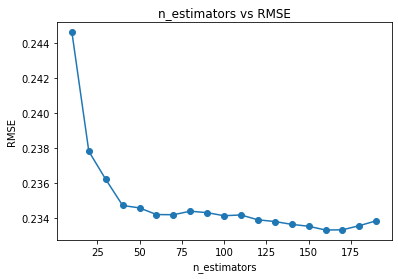

In [6]:
import matplotlib.pyplot as plt

params = []
rmse_values = []


for i in range(10,200,10):
    rf = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    params.append(i)
    rmse=np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append(rmse)
    print(f"n_estimators = {i}, RMSE = {rmse:.4f}")
    
    

# Plot the graph
plt.plot(params, rmse_values, marker='o')

# Set plot labels and title
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('n_estimators vs RMSE')

# Show the plot
plt.show()

In [7]:
scores=[]
for depth in [10, 15,20,25]:
    for n_est in range(10,200,10):
        rf=RandomForestRegressor(n_estimators=n_est, max_depth=depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred)
        scores.append((depth, n_est, rmse))
        

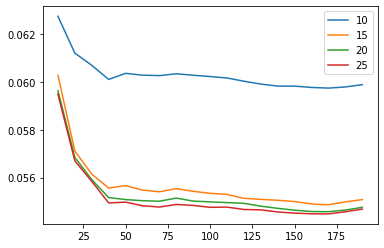

In [8]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

In [9]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.01504314, 0.03006329, 0.10266505, 0.08585341, 0.33548579,
       0.21881985, 0.14745955, 0.02811472, 0.01543366, 0.02106153])

In [10]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances

,feature,importance
0,households,0.015043
1,housing_median_age,0.030063
2,latitude,0.102665
3,longitude,0.085853
4,median_income,0.335486
5,ocean_proximity=<1H OCEAN,0.218820
6,ocean_proximity=INLAND,0.147460
7,population,0.028115
8,total_bedrooms,0.015434
9,total_rooms,0.021062


In [11]:
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.335486
5,ocean_proximity=<1H OCEAN,0.218820
6,ocean_proximity=INLAND,0.147460
2,latitude,0.102665
3,longitude,0.085853


In [13]:
import xgboost as xgb
import re

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns]

dtrain=xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval=xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [14]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [17]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [18]:
scores['eta=0.3'] = parse_xgb_output(output)

In [19]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [20]:
scores['eta=0.1'] = parse_xgb_output(output)

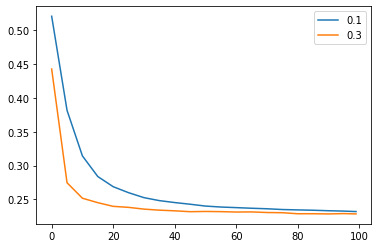

In [21]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()